# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [3]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`.

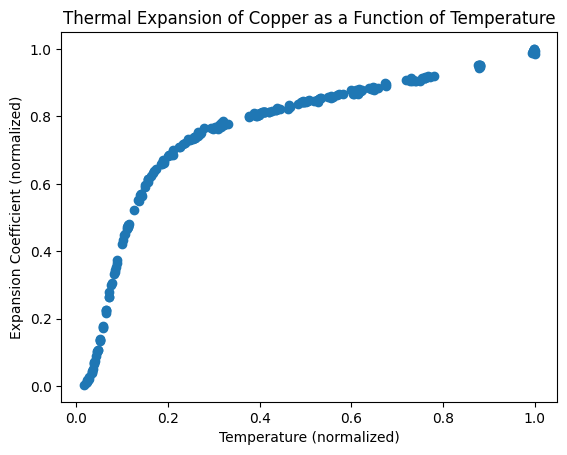

In [5]:
# TODO
# x0 = ...
# y0 = ...
# x = x0/np.max(x0)
# y = y0/np.max(y0)
# plt.plot(...)
x0 = df['x0'].values
y0 = df['y0'].values
x = x0 / x0.max()
y = y0 / y0.max()
plt.plot(x,y,'o')
plt.xlabel("Temperature (normalized)")
plt.ylabel("Expansion Coefficient (normalized)")
plt.title("Thermal Expansion of Copper as a Function of Temperature")
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

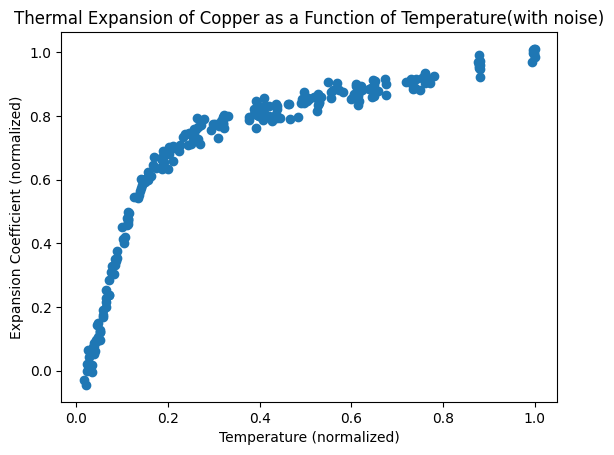

In [7]:
# TODO
# yn = y + ...
yn = y + np.random.normal(0,0.02,len(y))
plt.plot(x,yn,'o')
plt.xlabel("Temperature (normalized)")
plt.ylabel("Expansion Coefficient (normalized)")
plt.title("Thermal Expansion of Copper as a Function of Temperature(with noise)")
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [8]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [9]:
def predict(w, x):
    d = (len(w) - 1) // 2
    a = w[:d + 1]  #the first d+1 elements are coefficients for the numerator
    b = w[d + 1:]  #the next d elements are coefficients for the denominator

    numerator = np.polyval(a[::-1], x)
    denominator = 1 + np.polyval(b[::-1], x)
    y_hat = numerator / denominator

    return y_hat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ]

In [20]:
d = 3

# TODO.  Create the transformed feature matrix
# Z = ...
#Z = np.zeros((len(xtr), 2*d+1))
# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...


# Assume xtr and ytr are the training data arrays (already normalized as in previous steps)
N = len(xtr)  # Use the length of the training data, xtr

# Step 1: Create the transformed feature matrix Z for the training data
Z = np.zeros((N, 2 * d+1))  # Initialize Z with appropriate shape

# Fill Z with the required terms using xtr and ytr
for i in range(N):

    Z[i, :d] = [xtr[i] ** j for j in range(1, d + 1)]

    Z[i, d:2*d] = [ytr[i] * (xtr[i] ** j) for j in range(1, d + 1)]

    Z[i, -1] = 1

# Step 2: Fit with linear regression using the training data
regr = LinearRegression()
regr.fit(Z, ytr)  # Fit Z to ytr

# Step 3: Extract the parameters from the fitted model
winit = np.concatenate(([regr.intercept_], regr.coef_))

# winit now contains the initial estimates for [a[0], ..., a[d], b[0], ..., b[d-1]]
print("Initial parameter estimates (winit):", winit)


Initial parameter estimates (winit): [ -0.27947095  11.52074032 -40.34404201  33.59386547  -5.15883561
  30.83358749 -29.17056597   0.        ]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

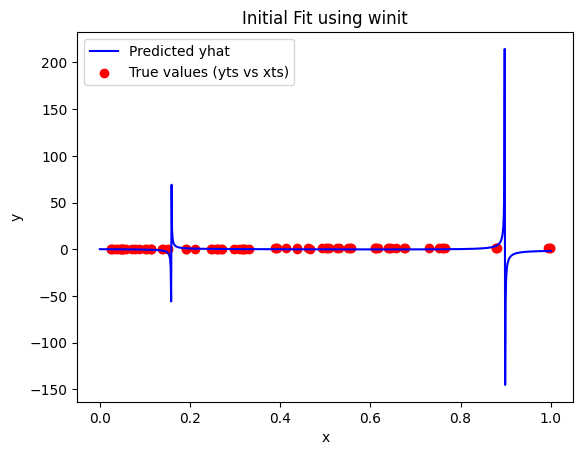

In [21]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp = np.linspace(0, 1, 1000)
yhat = predict(winit, xp)

plt.plot(xp, yhat, label="Predicted yhat", color="blue")
plt.scatter(xts, yts, color="red", label="True values (yts vs xts)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Initial Fit using winit")
plt.legend()
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

In [ ]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...

# TODO
# Plot the results as above.

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [ ]:
def feval(w,x,y):


    # TODO.  Parse w
    # a = ...
    # b = ...

    # TODO.  Znum[i,j] = x[i]**j

    # TODO.  Zden[i,j] = x[i]**(j+1)

    # TODO.  Compute yhat
    # Compute the numerator and denominator

    # TODO.  Compute loss
    # f = ...

    # TODO.  Compute gradients
    # fgrad = ...

    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [ ]:
# TODO

## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

In [ ]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

In [ ]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

In [ ]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

In [ ]:
# TODO
nit = 1000
step = 1e-3
beta = 0.99

In [ ]:
# TODO
# plot yhat vs. x

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.